In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, TensorDataset

import os
os.chdir("..")
import src.models as models
import src.utils as utils
import src.main as main
from tqdm import tqdm
from scipy.ndimage import convolve1d


%load_ext autoreload
%autoreload 

logger = utils.setup_logger(__name__)
logger(".")

2024-08-29 14:50:37 | .


---

## Settings
---

In [2]:
class Settings:
    num = 100
    load = True
    idx = 0
    use_bias = False
    
args = Settings()

if args.load:
    info, autoencoder = models.load_session(idx=args.idx)
    dim_ei = info["dim_ei"]
    dim_ca3 = info["dim_ca3"]
    dim_ca1 = info["dim_ca1"]
    dim_eo = info["dim_eo"]

    num_samples = info["num_samples"]

    K_lat = info["K_lat"]
    beta = info["beta"]
    K = info["K"]

    # get parameters
    W_ei_ca1, W_ca1_eo, B_ei_ca1, B_ca1_eo = autoencoder.get_weights(bias=True)

    logger("<<< Loaded session >>>")
else:
    dim_ei = 50
    dim_ca3 = 50 
    dim_ca1 = 50
    dim_eo = dim_ei

    # data settings
    num_samples = 300

    # model hyper-parameters
    K = 5
    K_lat = 15
    beta = 60

    # autoencoder
    autoencoder = Autoencoder(input_dim=dim_ei,
                              encoding_dim=dim_ca1,
                              activation=None,
                              K=K_lat,
                              beta=beta,
                              use_bias=args.use_bias)
    logger(f"%Autoencoder: {autoencoder}")

2024-08-29 14:50:37 | Saved sessions:
2024-08-29 14:50:37 | Pre-selected session: [0]
/Users/daniekru/Research/lab/KAMemory/src/models.py:405: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experime

[0] ae_20_1341
[1] ae_3
[2] ae_19_1731
[3] ae_20_1332
{'K': 5,
 'K_lat': 15,
 'beta': 60,
 'dim_ca1': 50,
 'dim_ca3': 50,
 'dim_ei': 50,
 'dim_eo': 50,
 'epochs': 500,
 'loss_ae': 0.05726,
 'num_reconstructions': 1,
 'num_samples': 10000}


### training **AE** from scratch

#### Dataset

In [3]:
training_samples = utils.sparse_stimulus_generator(N=num_samples,
                                                   K=K,
                                                   size=dim_ei,
                                                   plot=False)
test_samples = utils.sparse_stimulus_generator(N=num_samples,
                                               K=K,
                                               size=dim_ei,
                                               plot=False)

# dataset for btsp
num_btsp_samples = args.num
training_sample_btsp = training_samples[np.random.choice(
                        range(training_samples.shape[0]),
                        num_btsp_samples, replace=False)]


logger("<<< Data generated >>>")

2024-08-29 13:32:02 | <<< Data generated >>>


2024-08-29 13:32:03 | %MTL: MTL(dim_ei=50, dim_ca1=50, dim_ca3=50, dim_eo=50,  bias=False, lr=1.0,beta=60, alpha=0.01, K_l=15, K_o=5


0 0


/Users/daniekru/Research/lab/KAMemory/src/utils.py:401: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data[:k+1], dtype=torch.float32).detach()


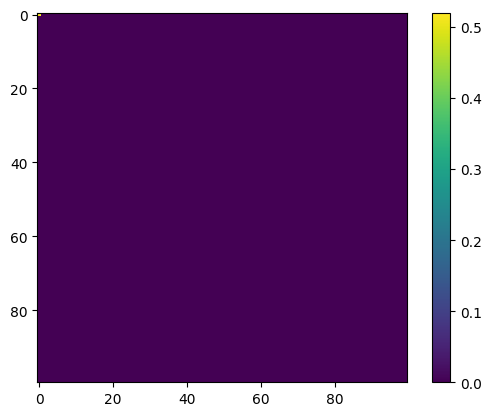

In [4]:
""" mtl training """

# get weights from the autoencoder
if args.use_bias:
    W_ei_ca1, W_ca1_eo, B_ei_ca1, B_ca1_eo = autoencoder.get_weights(bias=True)
else:
    W_ei_ca1, W_ca1_eo = autoencoder.get_weights(bias=False)
    B_ei_ca1 = None
    B_ca1_eo = None

# make model
model = models.MTL(W_ei_ca1=W_ei_ca1,
            W_ca1_eo=W_ca1_eo,
            B_ei_ca1=B_ei_ca1,
            B_ca1_eo=B_ca1_eo,
            dim_ca3=dim_ca3,
            lr=1.,
            K_lat=K_lat,
            K_out=K,
            beta=beta)

logger(f"%MTL: {model}")

# train model | testing = training without backprop
epochs = 1
for _ in range(epochs):
   # _, model = utils.testing(data=training_sample_btsp,
   #                                 model=model,
   #                                 column=True)

    #model.pause_lr()
    acc, _, = utils.progressive_testing(data=training_sample_btsp,
                                model=model)

plt.imshow(acc, vmin=0)
plt.colorbar();

#### **AE** training

In [5]:
# train autoencoder
if not args.load:
    epochs = 400
    loss_ae, autoencoder = utils.train_autoencoder(
                    training_data=training_samples,
                    test_data=test_samples,
                    model=autoencoder,
                    epochs=int(epochs),
                    batch_size=10, learning_rate=1e-3)
    logger(f"<<< Autoencoder trained [loss={loss_ae:.4f}] >>>")

# reconstruct data
out_ae, latent_ae = utils.reconstruct_data(data=training_sample_btsp,
                                num=num_btsp_samples,
                                model=autoencoder,
                                show=False, 
                                plot=False)

100%|██████████████████████████████████████████| 100/100 [00:00<00:00, 8181.29it/s]


In [3]:
W_ei_ca1, W_ca1_eo, B_ei_ca1, B_ca1_eo = autoencoder.get_weights(bias=True)

## Sim 2
---
making the $\alpha$**-plot** training each pattern only once

#### attempt 1

2024-08-27 18:16:51 | %MTL: MTL(dim_ei=50, dim_ca1=50, dim_ca3=50, dim_eo=50,  bias=False, lr=1.0,beta=60, alpha=0.01, K_l=15, K_o=5
100%|██████████████████████████████████████████| 100/100 [00:00<00:00, 6744.88it/s]


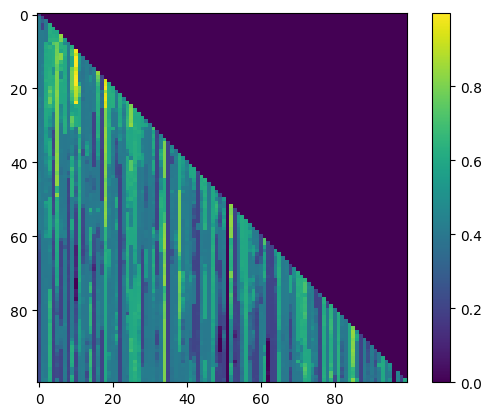

In [4]:
""" mtl training """

# get weights from the autoencoder
if args.use_bias:
    W_ei_ca1, W_ca1_eo, B_ei_ca1, B_ca1_eo = autoencoder.get_weights(bias=True)
else:
    W_ei_ca1, W_ca1_eo = autoencoder.get_weights(bias=False)
    B_ei_ca1, B_ca1_eo = None, None
    

#logger.debug(f"{W_ei_ca1.shape=}\n{type(W_ei_ca1)}")

# make model
model = models.MTL(W_ei_ca1=W_ei_ca1,
            W_ca1_eo=W_ca1_eo,
            B_ei_ca1=B_ei_ca1,
            B_ca1_eo=B_ca1_eo,
            dim_ca3=dim_ca3,
            lr=1.,
            K_lat=K_lat,
            K_out=K,
            beta=beta)

logger(f"%MTL: {model}")

# train model | testing = training without backprop
epochs = 1
for _ in range(epochs):
   # _, model = utils.testing(data=training_sample_btsp,
   #                                 model=model,
   #                                 column=True)

    #model.pause_lr()
    loss_mtl, _, _ = utils.testing(data=training_sample_btsp,
                                model=model,
                                column=True,
                                use_tensor=True,
                                progressive_test=True)
    #logger(f"<<< MTL trained [{loss_mtl:.3f}] >>>")

# reconstruct data
model.pause_lr()
out_mtl, latent_mtl = utils.reconstruct_data(
                                data=training_sample_btsp,
                                num=num_btsp_samples,
                                model=model,
                                column=True,
                                plot=False)

plt.imshow(loss_mtl, vmin=0)
plt.colorbar();

#### attempt 2

2024-08-27 18:17:02 | %MTL: MTL(dim_ei=50, dim_ca1=50, dim_ca3=50, dim_eo=50,  bias=False, lr=1.0,beta=60, alpha=0.01, K_l=15, K_o=5


torch.Size([1, 50])
torch.Size([1, 50])
torch.Size([1, 50])
torch.Size([1, 50])
torch.Size([1, 50])
torch.Size([1, 50])
torch.Size([1, 50])
torch.Size([1, 50])
torch.Size([1, 50])
torch.Size([1, 50])
torch.Size([1, 50])
torch.Size([1, 50])
torch.Size([1, 50])
torch.Size([1, 50])
torch.Size([1, 50])
torch.Size([1, 50])
torch.Size([1, 50])
torch.Size([1, 50])
torch.Size([1, 50])
torch.Size([1, 50])
torch.Size([1, 50])
torch.Size([1, 50])
torch.Size([1, 50])
torch.Size([1, 50])
torch.Size([1, 50])
torch.Size([1, 50])
torch.Size([1, 50])
torch.Size([1, 50])
torch.Size([1, 50])
torch.Size([1, 50])
torch.Size([1, 50])
torch.Size([1, 50])
torch.Size([1, 50])
torch.Size([1, 50])
torch.Size([1, 50])
torch.Size([1, 50])
torch.Size([1, 50])
torch.Size([1, 50])
torch.Size([1, 50])
torch.Size([1, 50])
torch.Size([1, 50])
torch.Size([1, 50])
torch.Size([1, 50])
torch.Size([1, 50])
torch.Size([1, 50])
torch.Size([1, 50])
torch.Size([1, 50])
torch.Size([1, 50])
torch.Size([1, 50])
torch.Size([1, 50])


/Users/daniekru/Research/lab/KAMemory/src/utils.py:423: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data[:k+1], dtype=torch.float32).detach()


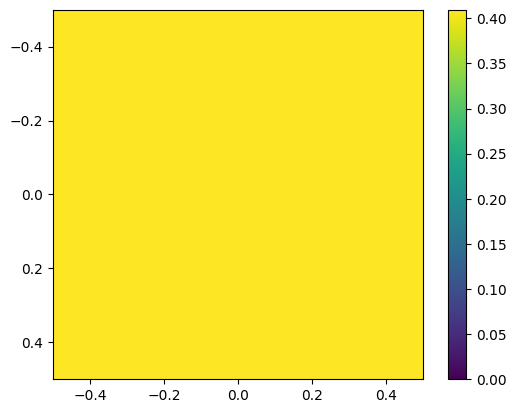

In [5]:
""" mtl training """

# get weights from the autoencoder
if args.use_bias:
    W_ei_ca1, W_ca1_eo, B_ei_ca1, B_ca1_eo = autoencoder.get_weights(bias=True)
else:
    W_ei_ca1, W_ca1_eo = autoencoder.get_weights(bias=False)
    B_ei_ca1 = None
    B_ca1_eo = None

# make model
model = models.MTL(W_ei_ca1=W_ei_ca1,
            W_ca1_eo=W_ca1_eo,
            B_ei_ca1=B_ei_ca1,
            B_ca1_eo=B_ca1_eo,
            dim_ca3=dim_ca3,
            lr=1.,
            K_lat=K_lat,
            K_out=K,
            beta=beta)

logger(f"%MTL: {model}")

# train model | testing = training without backprop
epochs = 1
for _ in range(epochs):
   # _, model = utils.testing(data=training_sample_btsp,
   #                                 model=model,
   #                                 column=True)

    #model.pause_lr()
    acc, _, = utils.progressive_testing(data=training_sample_btsp,
                                model=model)

plt.imshow(acc, vmin=0)
plt.colorbar();

In [9]:
acc.shape

torch.Size([1, 1])

100%|██████████████████████████████████████████████| 10/10 [00:10<00:00,  1.04s/it]


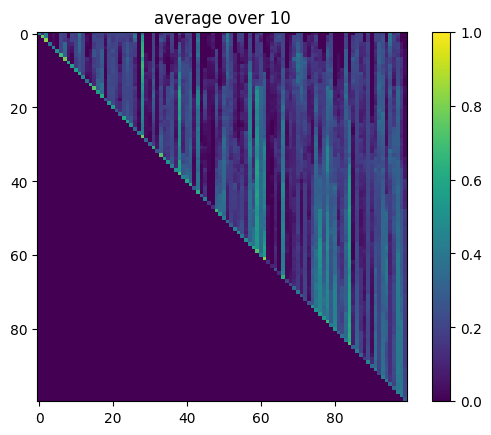

In [28]:
NUM_REP = 10

acc = np.zeros((args.num, args.num))
for _ in tqdm(range(NUM_REP)):
    model = models.MTL(W_ei_ca1=W_ei_ca1,
                W_ca1_eo=W_ca1_eo,
                B_ei_ca1=B_ei_ca1,
                B_ca1_eo=B_ca1_eo,
                dim_ca3=dim_ca3,
                lr=1.,
                K_lat=K_lat,
                K_out=K,
                beta=beta)
    
    #logger(f"%MTL: {model}")
    
    # train model | testing = training without backprop
    acc_epoch, _, _ = utils.testing(data=training_sample_btsp,
                                model=model,
                                column=True,
                                use_tensor=False,
                                progressive_test=True)

    acc += acc_epoch.numpy()
    
acc /= NUM_REP
plt.imshow(acc, vmin=0, vmax=1)
plt.title(f"average over {NUM_REP}")
plt.colorbar();

#### Plotting

In [ ]:
### """ plotting """

# fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 5), sharex=True)

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 5), sharex=True)
is_squash = False

utils.plot_squashed_data(
    data=training_sample_btsp,
                         ax=ax1,
                         title="Patterns", squash=is_squash)
utils.plot_squashed_data(data=latent_ae, ax=ax2,
                         title="Autoencoder",
                         squash=is_squash)
utils.plot_squashed_data(data=latent_mtl, ax=ax3,
                         title="MTL", squash=is_squash)

fig.suptitle(f"Latent layers - $K_l=${K_lat} $\\beta=${autoencoder._beta}")

#
fig2, (ax12, ax22, ax32) = plt.subplots(3, 1, figsize=(15, 5), sharex=True)
is_squash = False

utils.plot_squashed_data(
    data=training_sample_btsp,
                         ax=ax12,
                         title="Patterns", squash=is_squash)
utils.plot_squashed_data(data=out_ae, ax=ax22,
                         title="Autoencoder",
                         squash=is_squash)
utils.plot_squashed_data(data=out_mtl, ax=ax32,
                         title="MTL",
                         squash=is_squash)

fig2.suptitle(f"Data reconstruction of {num_btsp_samples} patterns - $K=${K} $\\beta=${autoencoder._beta}",
              fontsize=15)

#
fig3, (ax13) = plt.subplots(1, 1, figsize=(15, 5), sharex=True)
cbar = plt.colorbar(
    ax13.imshow(training_sample_btsp - out_mtl,
                cmap="seismic",
                aspect="auto"))
ax13.set_yticks(range(num_btsp_samples))

cbar.set_label("Error")
ax13.set_title("pattern - mtl")
plt.show()



In [ ]:
plt.imshow(loss_mtl, vmin=0)
plt.colorbar();

## $\alpha$-plot
---
training of the MTL for different values of $\alpha$, and average over multiple repetitions

In [54]:
""" data """

num_samples = 200
num_rep = 20
datasets = []

stimuli = utils.sparse_stimulus_generator(N=num_samples,
                                          K=K,
                                          size=dim_ei,
                                          plot=False)

datasets = []
for k in range(num_samples):
    data = torch.tensor(stimuli[:k+1], dtype=torch.float32)
    dataloader = DataLoader(TensorDataset(data),
                            batch_size=1,
                            shuffle=False)
    datasets += [dataloader]


In [55]:
""" run """

num_alphas = 2
if num_alphas < 2:
    alphas = [0.4]
else:
    alphas = [0.01, 0.04, 0.08, 0.2, 0.6, 1.]
    #alphas = np.around(np.linspace(0.075, 0.3, num_alphas), 2)
    num_alphas = len(alphas)

outputs = np.zeros((num_rep, num_alphas, num_samples, num_samples))

for l in tqdm(range(num_rep)):
    for h, alpha in enumerate(alphas):

        # data
        stimuli = utils.sparse_stimulus_generator(N=num_samples,
                                                  K=K,
                                                  size=dim_ei,
                                                  plot=False)

        datasets = []
        for k in range(num_samples):
            data = torch.tensor(stimuli[:k+1], dtype=torch.float32)
            dataloader = DataLoader(TensorDataset(data),
                                    batch_size=1,
                                    shuffle=False)
            datasets += [dataloader]

        # run
        for i in tqdm(range(num_samples), disable=True):

            # make model
            model = models.MTL(W_ei_ca1=W_ei_ca1,
                        W_ca1_eo=W_ca1_eo,
                        B_ei_ca1=B_ei_ca1,
                        B_ca1_eo=B_ca1_eo,
                        dim_ca3=dim_ca3,
                        lr=1.,
                        K_lat=K_lat,
                        K_ca3=10,
                        K_out=K,
                        beta=beta,
                        alpha=alpha)

            # train a dataset with pattern index 0.. i
            model.eval()
            with torch.no_grad():

                # one pattern at a time
                for batch in datasets[i]:
                    # forward
                    _ = model(batch[0].reshape(-1, 1))

            # test a dataset with pattern index 0.. i 
            model.pause_lr()
            model.eval()
            with torch.no_grad():
                # one pattern at a time
                for j, batch in enumerate(datasets[i]):
                    x = batch[0].reshape(-1, 1)

                    # forward
                    y = model(x)
                    # logger.debug(f"{x.shape}, {y.shape}")

                    # record : cosine similarity
                    # outputs[l, h, i, j] = (y.T @ x) / \
                    #     (torch.norm(x) * torch.norm(y))

                    value = (y.T @ x) / \
                        (torch.norm(x) * torch.norm(y))

                    outputs[l, h, i, j] = (value.item() - 0.2) / 0.8

100%|██████████████████████████████████████████████| 20/20 [08:57<00:00, 26.85s/it]


#### Plot

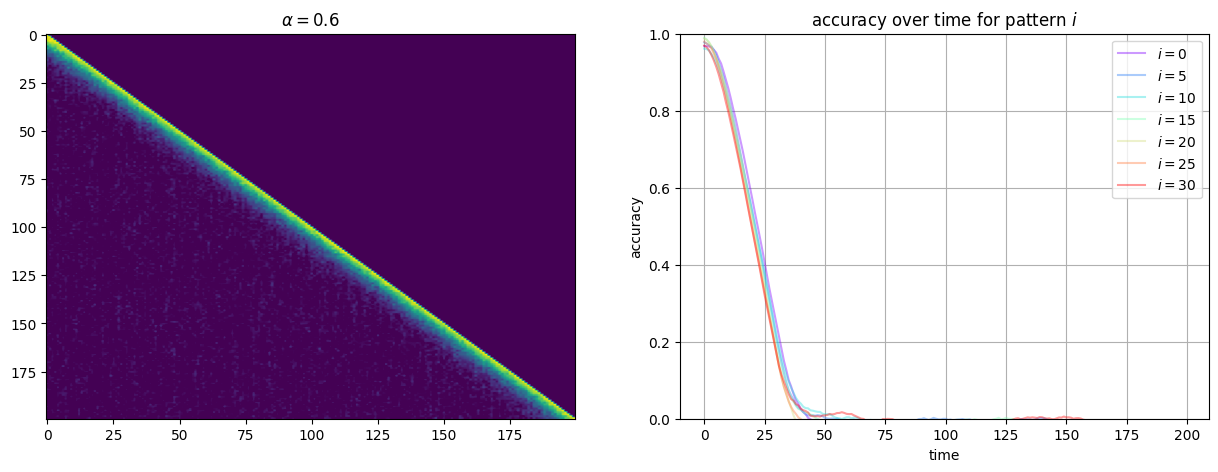

In [80]:
i = 4
outputs1 = outputs.mean(axis=0)[i]
# -> (sample, sample)

fig0 = plt.figure(figsize=(15, 5))

plt.subplot(121)
plt.imshow(outputs1, cmap="viridis",
           vmin=0, vmax=1, aspect="auto")
plt.title(f"$\\alpha=${alphas[i]}")

plt.subplot(122)
# plt.axhline(0.1, color="r", linestyle="--",
#             alpha=0.2)
# smoothing
num_p = 7
jumps = 5
colors = plt.cm.rainbow(np.linspace(0, 1, num_p))
for di, d in enumerate(range(0, jumps*num_p, jumps)):
    output_d = outputs1[d:, d] # selection of one pattern
    nsmooth = 30
    padded_d = np.pad(output_d, (nsmooth-1, 0), mode="edge")
    output_d = np.convolve(padded_d,
                          np.ones(nsmooth)/nsmooth,
                          mode="valid")
    plt.plot(output_d, '-', label=f"$i=${d}", alpha=0.4,
             color=colors[di])

plt.ylim(0., 1)
plt.ylabel("accuracy")
plt.xlabel("time")
plt.legend()
plt.title("accuracy over time for pattern $i$")
plt.grid()

plt.show()


## Memory capacity

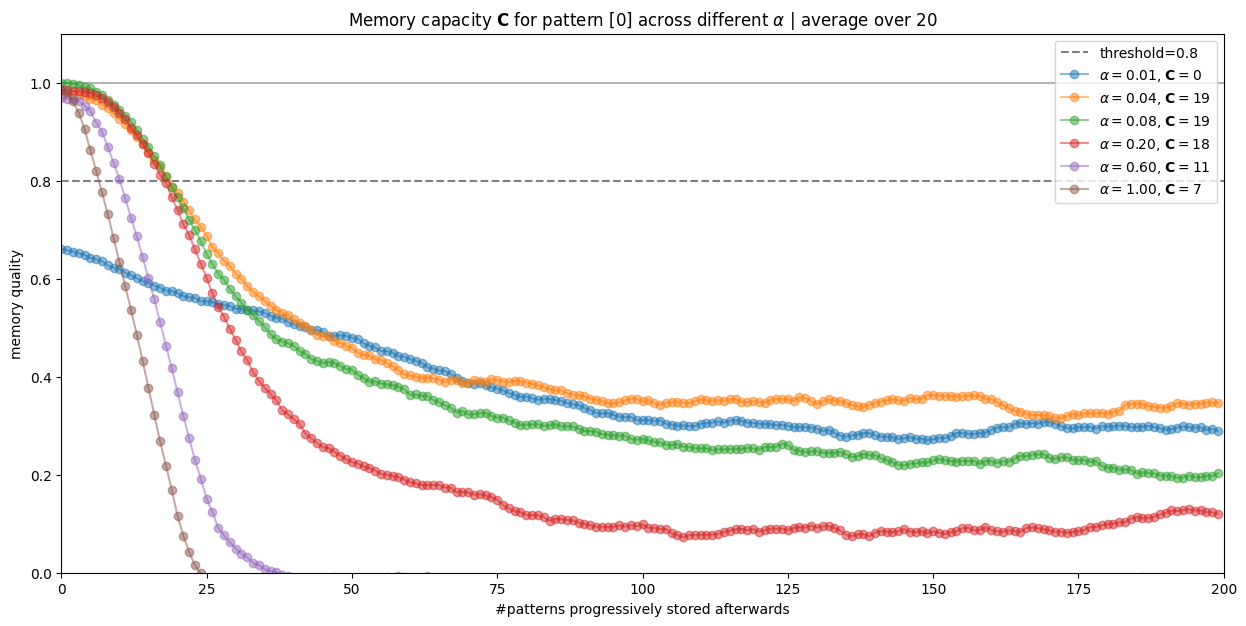

In [73]:
threshold = 0.8
idx_pattern = 0
nsmooth = 20
tot = outputs.shape[-1]

fig1 = plt.figure(figsize=(15, 7))
plt.axhline(threshold, color="black", linestyle="--", label=f"threshold={threshold}", alpha=0.5)
plt.axhline(1., color="black", alpha=0.3)
#plt.axvline(idx_pattern, color="black", alpha=0.3)


for i, out in enumerate(outputs.mean(axis=0)):
    out = out[idx_pattern:]

    # calculate the memory capacity
    capacity = utils.calc_capacity(outputs=out,
                                   threshold=threshold,
                                   nsmooth=nsmooth,
                                   idx_pattern=idx_pattern)

    # smooth
    padded_out = np.pad(out[:, idx_pattern],
                        (nsmooth-1, 0), mode="edge")
    out = np.convolve(padded_out,
                      np.ones(nsmooth)/nsmooth,
                      mode="valid")

    
    plt.plot(range(len(out)), out, 'o-', alpha=0.5, label=f"$\\alpha=${alphas[i]:.2f}, $\mathbf{{C}}=${capacity}")
plt.ylim(0, 1.1)
plt.ylabel("memory quality")
plt.xlim(0, len(out))
plt.xlabel("#patterns progressively stored afterwards")
plt.legend(loc="upper right")
plt.title(f"Memory capacity $\mathbf{{C}}$ for pattern [{idx_pattern}] across different $\\alpha$ | average over {num_rep}")
#plt.grid()
plt.show()

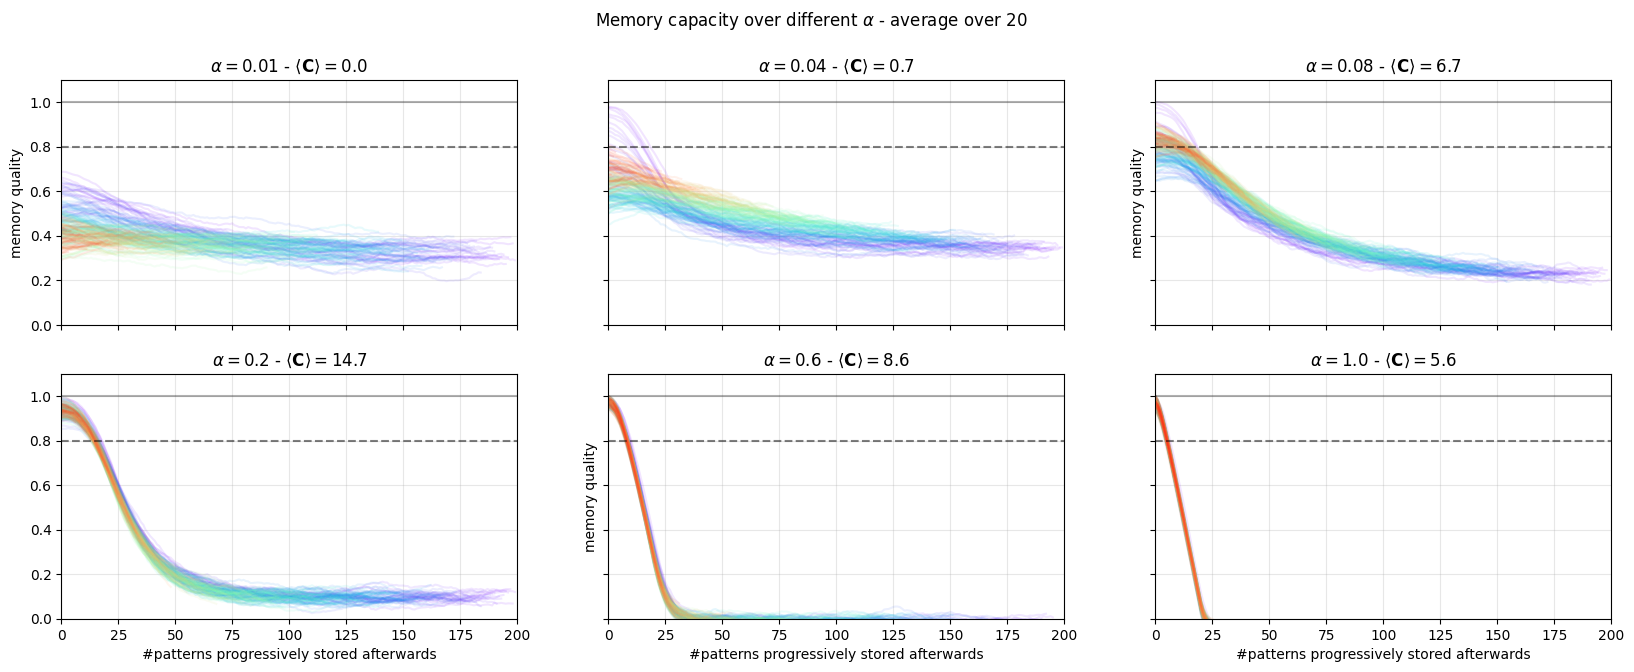

In [62]:
threshold = 0.8
nsmooth = 20
tot = outputs.shape[-1]

fig, axs = plt.subplots(2, 3, figsize=(20, 7), sharex=True, sharey=True)
axs = axs.flatten()
fig.suptitle(f"Memory capacity over different $\\alpha$ - average over {num_rep}")
ia = 0
colors = plt.cm.rainbow(np.linspace(0, 1, tot))

outs = outputs.mean(axis=0)

for k, ax in enumerate(axs):
    C = 0
    for i in range(tot):
            
        # calculate the memory capacity
        capacity = utils.calc_capacity(outputs=outs[k],
                                       threshold=threshold,
                                       nsmooth=nsmooth,
                                       idx_pattern=i)
        C += capacity
    
        # smooth
        padded_out = np.pad(outs[k, i:, i],
                            (nsmooth-1, 0), mode="edge")
        out = np.convolve(padded_out,
                          np.ones(nsmooth)/nsmooth,
                          mode="valid")
        
        ax.plot(range(len(out)), out, '-', alpha=0.1, color=colors[i])#, label=f"$i=${i}, $\mathbf{{C}}=${capacity}")

    ax.axhline(threshold, color="black", linestyle="--", label=f"threshold={threshold}", alpha=0.5)
    ax.axhline(1., color="black", alpha=0.3)
    ax.set_ylim(0, 1.1)       
    ax.grid(alpha=0.3)
    if k % 2 == 0:
        ax.set_ylabel("memory quality")
    ax.set_xlim(0, tot)
    if k > 2:
        ax.set_xlabel("#patterns progressively stored afterwards")

    ax.set_title(f"$\\alpha=${alphas[k]} - $\\langle \\mathbf{{C}}\\rangle=${C/tot:.1f}")
#plt.grid()
plt.show()